# Basic optimization

In [1]:
from contra_qa.text_generation.boolean2_S_and import boolean2
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels, plot_confusion_matrix, simple_step_plot

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

In [2]:
boolean2()
df2 = pd.read_csv("data/boolean2_train.csv")

In [3]:
df2.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Robert is witty and Nina is nice,Robert is not witty,Robert is witty,Nina is nice,1
9996,Byron is mealy and Elaine is rich,Elaine is not rich,Byron is mealy,Elaine is rich,1
9997,Bertha is agreeable and Lynn is aggressive,Bertha is not agreeable,Bertha is agreeable,Lynn is aggressive,1
9998,Melinda is ambitious and Brad is kind,Nancy is unimportant,Melinda is ambitious,Brad is kind,0
9999,Douglas is gentle and Manuel is mushy,Manuel is not gentle,Douglas is gentle,Manuel is mushy,0


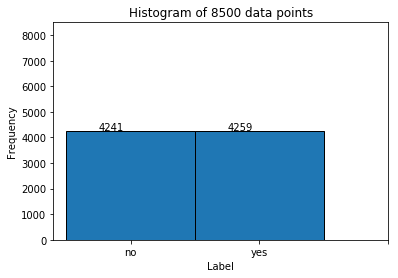

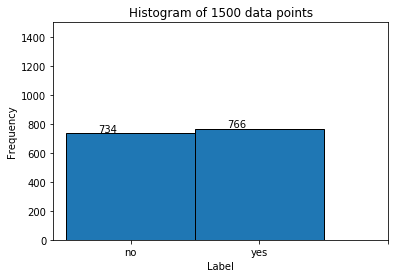

In [4]:
df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]
plot_histogram_from_labels(df2train.label.values, ["no", "yes"], "test.png") 
plot_histogram_from_labels(df2valid.label.values, ["no", "yes"], "test.png")

In [5]:
simple_pre_process_text_df(df2, "sentence1")
simple_pre_process_text_df(df2, "sentence2")
simple_pre_process_text_df(df2, "and_A")
simple_pre_process_text_df(df2, "and_B")

df2["text"] = df2["sentence1"] + ", " + df2["sentence2"]
df2_little = df2[["text", "label"]]

df2_little.head()

,text,label
0,"george is delightful and jesse is brave, georg...",1
1,"juan is witty and bradley is jolly, mathew is ...",0
2,"earl is delightful and gail is zealous, carlos...",0
3,"pamela is calm and andrea is witty, arthur is ...",0
4,"kim is witty and joseph is agreeable, kim is n...",1


In [6]:
train_data_path = "data/boolean_2_train_lab.csv"
df2_little.to_csv(train_data_path, header=False, index=False)
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [7]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 753
len(LABEL.vocab): 2


In [8]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [9]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)

In [10]:
s1_t = str_list2tensor(list(df2train.sentence1.values))
y_t = torch.tensor(list(df2train.label.values),
                   dtype=torch.long,
                   device=device)

In [11]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)
valid_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)
test_dataset = TensorDataset(s1_t, s1_t, s1_t, s1_t, y_t)

In [12]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [13]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   embedding_dim=10,
                   rnn_dim=10,
                   learning_rate=0.02)

test_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

In [14]:
class AddRNN(nn.Module):
    def __init__(self, config):
        super(AddRNN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_dim = config.embedding_dim
        self.output_dim = config.output_dim
        self.rnn_dim = config.rnn_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.RNN(self.embedding_dim, self.rnn_dim) 
        self.fc_out = nn.Linear(self.rnn_dim, self.output_dim)

    def forward(self, x):
        """
        Apply the model to the input x
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        # output = [sent len, batch size, hid dim]
        # hidden = [1, batch size, hid dim]

        self.output = output

        hidden = hidden.squeeze(0)
        out = self.fc_out(hidden)
        return out

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

In [15]:
def train_in_epoch(model, iterator, optimizer, criterion):
    """
    Train the model using all the data from the iterator
    Negative is a flag to train the model to maximize the
    loss function
    :param model: RNN classification model
    :type model: RNN
    :param iterator: data iterator
    :type iterator: data.BucketIterator
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterion: loss criterion
    :type criterion: nn.CrossEntropyLoss
    :param negative: control param
    :type negative: boolean
    :return: mean loss, mean accuracy
    :rtype: float, float
    """

    epoch_loss = []
    epoch_acc = []

    model.train()

    for batch in iterator:

        optimizer.zero_grad()
        s1, s2, ha, hb, label = batch
        s1 = s1.view(s1.shape[1], s1.shape[0])

        logits = model(s1)
        loss = criterion(logits, label)
        pred = model.predict(s1)
        acc = np.mean(torch.eq(pred, label).numpy())
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)

        loss.backward()
        optimizer.step()

    return epoch_loss, epoch_acc

## Vizualizing the train loss and acc during epochs

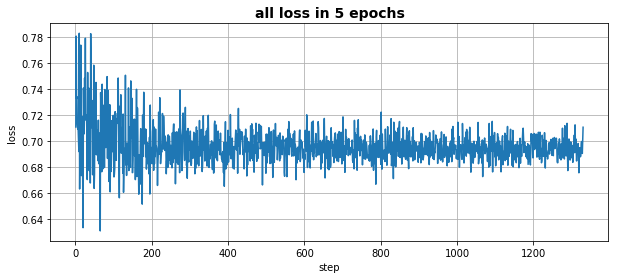

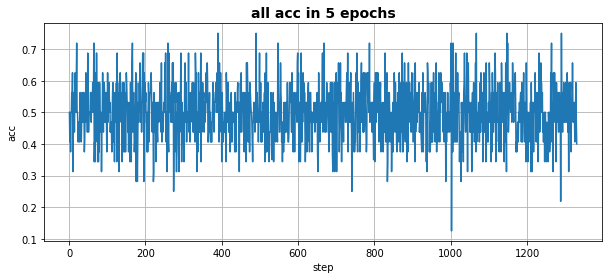

In [16]:
model = AddRNN(config)
iterator = test_data.train_loader
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)
criterion = nn.CrossEntropyLoss()

all_loss = []
all_acc = []

epochs = 5

for i in range(epochs):
    loss, acc = train_in_epoch(model,
                               iterator,
                               optimizer,
                               criterion)
    all_loss += loss
    all_acc += acc
    
#     simple_step_plot([loss],
#                      yname="loss",
#                      path="loss.png",
#                      title="loss in epoch {}".format(i+1),
#                      figsize=(10,4))

#     simple_step_plot([acc],
#                      yname="acc",
#                      path="acc.png",
#                      title="acc in epoch {}".format(i+1),
#                      figsize=(10,4))

    
    
simple_step_plot([all_loss],
                 yname="loss",
                 path="loss.png",
                 title="all loss in {} epochs".format(epochs),
                 figsize=(10,4))

simple_step_plot([all_acc],
                 yname="acc",
                 path="acc.png",
                 title="all acc in {} epochs".format(epochs),
                 figsize=(10,4))